# Lab 7: Recurrent Network Architectures

BY Yifan Ding

# 1. Preparation  (30 points total) 

## 1.1 Dataset Overview

This dataset, “Quora Insincere Questions Classification,” is obtained from Kaggle under 'Featured Code Competition'. Quora is a place to gain and share knowledge. It's a platform to ask questions and connect with people who contribute unique insights and quality answers.
An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

a.Has a non-neutral tone

b.Is rhetorical and meant to imply a statement about a group of people

c.Is disparaging or inflammatory

d.Isn't grounded in reality

e.Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

## Purpose
The purpose of this dataset was to develop an recurrent neural network that will be able to distinguish between insincere and sincere quora questions in order to assist us to filter insincere questions on quora and focus more on the sincere questions.  There are two different classifications: sincere(marked as 0) and insincere(marked as 1). 

## False Positive vs True Negative Trade-off
In all classification problems, it is important to consider which is worse: false positives or false negatives. In this case, we will define a false positive as when the algorithm predicts that a question is insincere even when it is sincere.  A false negative is when the classifier predicts that the question is sincere even when it is insincere.  In this case, it is clear that we want to limit the amount of false negatives and instead have more false positives. 

## Citation for business understanding

“Quora Insincere Questions Classification.” Kaggle, https://www.kaggle.com/c/quora-insincere-questions-classification/data.

In [1]:
import os
import sys
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import itertools
import seaborn as sns
import math
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, MaxPooling1D
from keras.models import Model
from keras.models import Sequential, load_model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
df_all = pd.read_csv("/Users/yifan/Downloads/lessons/7324/lab7/train.csv")
print("Train shape : ", df_all.shape)

Train shape :  (1306122, 3)


In [3]:
df_all["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

It's so time-consuming to run all the data. We decide to use subset of orginal dataset.

In [4]:
random.seed(2019)
df = df_all.sample(round(0.025*len(df_all.target)))

In [5]:
df["target"].value_counts()

0    30568
1     2085
Name: target, dtype: int64

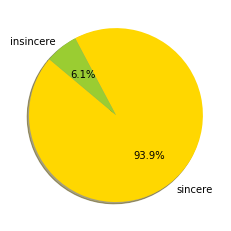

In [6]:
# Pie chart to show the class percentage
labels = 'sincere','insincere'
sizes = [30654,1999]
colors = ['gold', 'yellowgreen']

# Plot
plt.pie(sizes,labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.show()

From the pit chart above, 6.1% questions are classified as insincere, and 93.9% records are normal questions. Our dataset is obviously an imbalance dataset.

In [7]:
df['question_text'].isnull().any() #Check for missing data

False

In [8]:
## fill up the missing values
df_X = df["question_text"].fillna("_na_").values
df_X

array(['Which documents are needfor getting non cremylayercertificate?',
       'Is modern day mocking style humor really funny?',
       'Which are the best sources to learn JavaScript?', ...,
       'How do I date Nepalese girls in San Francisco Bay Area?',
       "Why isn't Arvind Kejriwal, one of the most honest person in India PM of India?",
       'Does a UPSC topper AIR 20 have superpowers like in Infinity War? How did he able to attend so many classes? What are his formulae for time management? How was he able to do a class at Vajiram, then at unique in Pune, then another at Chanakya, etc.?'],
      dtype=object)

In [9]:
## Get the target values
df_y = df['target'].values

In [10]:
NUM_TOP_WORDS = 50000 # how many unique words to use (i.e num rows in embedding vector)
MAX_ART_LEN = 100 # max number of words in a question to use

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df_X)
sequences = tokenizer.texts_to_sequences(df_X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(df_y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 30049 unique tokens. Distilled to 30049 top words.
Shape of data tensor: (32653, 100)
Shape of label tensor: (32653, 2)
30049


## Methods of Tokenization and Same Length Sequences (10 Points)

The tokenizer class from Keras will convert a text document into a list of integers where each integer represents a word.  In this representation, the integer is called a token.  In our implementation, we use every word found in all of the documents. We also bound the number of words from each document to only the first 1000. If a document does not have 100 words, then it is zero-padded on the left.  The tokens also only represent words-- the punctuation is completely scrubbed from the documents.

## 1.2 Train and Test set Split (10 Points)

In [11]:
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=df_y, 
                                                            random_state=42)
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(26122, 100) (26122, 2)
[24454.  1668.]


Since we have more than 26000 lines of sample text data for training, the training set is large enough that we do not need to implement a k fold cross validation. To make the result reproducible, we set a random seed. We separate the sample data set to a 80/20 training and test split.

## 1.3 Evaluation Metric (10 points)

## Metrics measurement

As we mentioned in False Positive vs False Negative Trade-off, in all classification problems, it is important to consider which is worse: false positives or false negatives. In this case, we will define a false positive as when the algorithm predicts that a child has pneumonia even when he or she doesn’t. A false negative is when the classivier predicts that the child does not have pneumonia even when the child does. In this case, it is clear that we want to limit the amount of false negatives. We also want to keep children from unnessary treatment, which will happen in false positive situation.

Since higher recall ratio illustrates lower false negative and we also concer about lower false positive, we should use **F1-score** as our main metric. F1-score are defined for binary classes. There are two ways to combine it into multiple classes. **micro** is calculated for the individual TPs, TNs, FPs, FNs of the confusion matrix, which weights each instance equally. **macro** is calculated as the average scores of the confusion matrix, which weights each class equally to evaluate the overall performance. Since we have an imbalanced instance for each class, we perfer to use F1 weighted macro-average score.

Given the metric for $K^{th}$ classes $X_k$:
$$F1_{micro} = \frac {2\times (TP_1 + ... + TP_k) } {2\times (TP1_1 +  ... + TP_k) + FP_1 +  ... + FP_k + FN_1 + ... + FN_k} $$

$$F1_{macro} = \frac {X_1  + ... + X_k} {k} $$

## Add F1-Score

Reference
Guglielmocamporese. “Macro F1-Score Keras.” Kaggle, Kaggle, 20 Oct. 2018, https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras.

In [12]:
import keras.backend as K
import tensorflow as tf
from tensorflow import math

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# 2. Modeling  (60 points total) 


## 2.1 Basic RNN ( 20 points)

## LSTM

We investigate two different recurrent network architectures. One is Long Short Term Memory (LSTM) architecture, the other is Gated Recurrent Unit architecture (GRU). The main hyperparemeters that we experimented with were unit, dropout and recurrent dropout. 

In [13]:
!ls "/Users/yifan/Downloads/lessons/7324/lab7//" 

Kathy_1212.ipynb              glove.6B
Kathy_1214.ipynb              lab 7 yifan 12-14 1pm.ipynb
Kathy_1216.ipynb              lab 7 yifan 12-17 2pm.ipynb
Lab7_Chan_Chen_Li_Final.ipynb train.csv


In [14]:
%%time
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/Users/yifan/Downloads/lessons/7324/lab7/glove.6B/glove.6B.300d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(30050, 300)
CPU times: user 35 s, sys: 1.21 s, total: 36.2 s
Wall time: 39.9 s


In [15]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [16]:
#change learning rate
keras.optimizers.Adam(learning_rate=0.001)

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2,activation='relu',return_sequences=True))
rnn.add(GlobalMaxPool1D())
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1])
print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9015000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           93440     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 9,108,570
Trainable params: 93,570
Non-trainable params: 9,015,000
_________________________________________________________________
None


In [84]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=128)

Train on 26122 samples, validate on 6531 samples
Epoch 1/15
26122/26122 [==============================] - 62s 2ms/step - loss: 0.2201 - accuracy: 0.9347 - f1: 0.5460 - val_loss: 0.1569 - val_accuracy: 0.9401 - val_f1: 0.6493
Epoch 2/15
26122/26122 [==============================] - 56s 2ms/step - loss: 0.1476 - accuracy: 0.9466 - f1: 0.6768 - val_loss: 0.1467 - val_accuracy: 0.9422 - val_f1: 0.6791
Epoch 3/15
26122/26122 [==============================] - 46s 2ms/step - loss: 0.1376 - accuracy: 0.9493 - f1: 0.7046 - val_loss: 0.1429 - val_accuracy: 0.9446 - val_f1: 0.7071
Epoch 4/15
26122/26122 [==============================] - 47s 2ms/step - loss: 0.1300 - accuracy: 0.9505 - f1: 0.7118 - val_loss: 0.1382 - val_accuracy: 0.9473 - val_f1: 0.7016
Epoch 5/15
26122/26122 [==============================] - 55s 2ms/step - loss: 0.1237 - accuracy: 0.9531 - f1: 0.7367 - val_loss: 0.1386 - val_accuracy: 0.9472 - val_f1: 0.7088
Epoch 6/15
26122/26122 [==============================] - 52s 2ms/

After 8 epochs we can see that the LSTM rnn has been converged after 10 epochs as the validation loss begin to increase. Loss for train set are decressing faster than validation set, which indicates potential over-fitting.

In [18]:
def confusion_rnn(rnn, X_test, y_test_ohe, title):
    yhat = np.argmax(rnn.predict(X_test), axis=1)
    y_test = np.argmax(y_test_ohe, axis = 1)
    cm = metrics.confusion_matrix(y_test, yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    acc = metrics.accuracy_score(y_test, yhat)
    f1 = metrics.f1_score(y_test, yhat, average="macro")
    plt.title("Using " + str(title) + ": " +' Acc: {:.4f}'.format(acc) + ' F1: {:.4f}'.format(f1))
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.show()

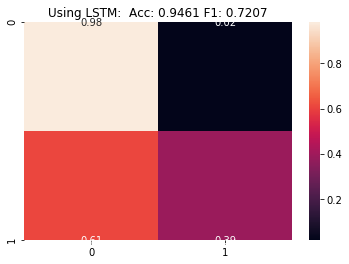

In [85]:
confusion_rnn(rnn, X_test, y_test_ohe, 'LSTM')

It is obvious that this LSTM model does not perform well for the classify the target=1(the positive value, which means the question is insincere), since we only get 0.39 true positive rate. So we want to check if we can find a threshold of f1 score to make our model performance better.

## Reference for threshold_search
Sudalairajkumar. “A Look at Different Embeddings.!” Kaggle, Kaggle, 8 Nov. 2018, https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings.

In [86]:
#Search for the threshold for best f1
#https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings/notebook
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = metrics.f1_score(y_true, (y_proba> threshold).astype(int),average = "macro")
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


test_pred = np.argmax(rnn.predict([X_test], batch_size=128, verbose=1),axis=1)
y_test = np.argmax(y_test_ohe,axis=1)
search_result = threshold_search(y_test, test_pred)

6531/6531 [==============================] - 5s 741us/step


In [87]:
search_result

{'threshold': 0.0, 'f1': 0.7207439209977513}

In [88]:
y_test = np.argmax(y_test_ohe,axis=1)
#All the f1
test_pred = np.argmax(rnn.predict(X_test),axis=1)
for thresh in np.arange(0, 0.51, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test, (test_pred > thresh).astype(int),average = "macro")))

F1 score at threshold 0.0 is 0.7207439209977513
F1 score at threshold 0.01 is 0.7207439209977513
F1 score at threshold 0.02 is 0.7207439209977513
F1 score at threshold 0.03 is 0.7207439209977513
F1 score at threshold 0.04 is 0.7207439209977513
F1 score at threshold 0.05 is 0.7207439209977513
F1 score at threshold 0.06 is 0.7207439209977513
F1 score at threshold 0.07 is 0.7207439209977513
F1 score at threshold 0.08 is 0.7207439209977513
F1 score at threshold 0.09 is 0.7207439209977513
F1 score at threshold 0.1 is 0.7207439209977513
F1 score at threshold 0.11 is 0.7207439209977513
F1 score at threshold 0.12 is 0.7207439209977513
F1 score at threshold 0.13 is 0.7207439209977513
F1 score at threshold 0.14 is 0.7207439209977513
F1 score at threshold 0.15 is 0.7207439209977513
F1 score at threshold 0.16 is 0.7207439209977513
F1 score at threshold 0.17 is 0.7207439209977513
F1 score at threshold 0.18 is 0.7207439209977513
F1 score at threshold 0.19 is 0.7207439209977513
F1 score at threshold 

We didn't find a better threshold for LSTM model. We processed with defalut threshold then.

## GRU

In [89]:
rnn_gru = Sequential()
rnn_gru.add(embedding_layer)
rnn_gru.add(GRU(64,dropout=0.2, recurrent_dropout=0.2,activation='relu',return_sequences=True))
rnn_gru.add(GlobalMaxPool1D())
rnn_gru.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_gru.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1])
print(rnn_gru.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9031200   
_________________________________________________________________
gru_13 (GRU)                 (None, 100, 64)           70080     
_________________________________________________________________
global_max_pooling1d_30 (Glo (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 130       
Total params: 9,101,410
Trainable params: 70,210
Non-trainable params: 9,031,200
_________________________________________________________________
None


In [90]:
rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=128)

Train on 26122 samples, validate on 6531 samples
Epoch 1/12
26122/26122 [==============================] - 48s 2ms/step - loss: 0.1997 - accuracy: 0.9378 - f1: 0.5426 - val_loss: 0.1601 - val_accuracy: 0.9397 - val_f1: 0.5902
Epoch 2/12
26122/26122 [==============================] - 44s 2ms/step - loss: 0.1455 - accuracy: 0.9466 - f1: 0.6727 - val_loss: 0.1486 - val_accuracy: 0.9422 - val_f1: 0.6525
Epoch 3/12
26122/26122 [==============================] - 44s 2ms/step - loss: 0.1347 - accuracy: 0.9488 - f1: 0.7005 - val_loss: 0.1439 - val_accuracy: 0.9439 - val_f1: 0.6876
Epoch 4/12
26122/26122 [==============================] - 46s 2ms/step - loss: 0.1264 - accuracy: 0.9512 - f1: 0.7211 - val_loss: 0.1423 - val_accuracy: 0.9459 - val_f1: 0.6975
Epoch 5/12
26122/26122 [==============================] - 42s 2ms/step - loss: 0.1213 - accuracy: 0.9529 - f1: 0.7316 - val_loss: 0.1399 - val_accuracy: 0.9478 - val_f1: 0.7074
Epoch 6/12
26122/26122 [==============================] - 40s 2ms/

After 8 epochs we can see that the GRU rnn has been converged after 9 epochs as the validation loss stay quiet stand.

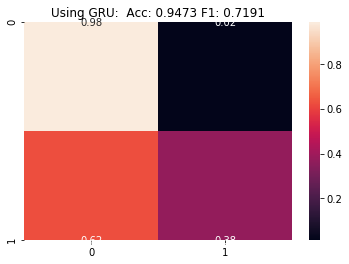

In [91]:
confusion_rnn(rnn_gru, X_test, y_test_ohe, 'GRU')

This GRU model also does not perform well for the classify the target=1(the positive value, which means the question is insincere), since we only get 0.38 true positive rate.

In [92]:
test_pred_gru = np.argmax(rnn_gru.predict([X_test], batch_size=128, verbose=1),axis=1)
search_result_gru = threshold_search(y_test, test_pred_gru)

6531/6531 [==============================] - 5s 729us/step


In [93]:
y_test = np.argmax(y_test_ohe,axis=1)
#All the f1
test_pred = np.argmax(rnn_gru.predict([X_test], batch_size=128, verbose=1),axis=1)
for thresh in np.arange(0, 0.51, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test, (test_pred > thresh).astype(int),average = "macro")))

6531/6531 [==============================] - 4s 670us/step
F1 score at threshold 0.0 is 0.719068393005945
F1 score at threshold 0.01 is 0.719068393005945
F1 score at threshold 0.02 is 0.719068393005945
F1 score at threshold 0.03 is 0.719068393005945
F1 score at threshold 0.04 is 0.719068393005945
F1 score at threshold 0.05 is 0.719068393005945
F1 score at threshold 0.06 is 0.719068393005945
F1 score at threshold 0.07 is 0.719068393005945
F1 score at threshold 0.08 is 0.719068393005945
F1 score at threshold 0.09 is 0.719068393005945
F1 score at threshold 0.1 is 0.719068393005945
F1 score at threshold 0.11 is 0.719068393005945
F1 score at threshold 0.12 is 0.719068393005945
F1 score at threshold 0.13 is 0.719068393005945
F1 score at threshold 0.14 is 0.719068393005945
F1 score at threshold 0.15 is 0.719068393005945
F1 score at threshold 0.16 is 0.719068393005945
F1 score at threshold 0.17 is 0.719068393005945
F1 score at threshold 0.18 is 0.719068393005945
F1 score at threshold 0.19 is 0

## Adjust parameters

In [19]:
type_list = [LSTM]
units_list = [32,64]
dropout_list = [0.1, 0.2]
recurrent_dropout_list = [0.1, 0.2]
rnn_list = {}

for (t, u, d, r) in itertools.product(type_list, units_list, dropout_list, recurrent_dropout_list):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(t(u,dropout=d, recurrent_dropout=r,activation='relu',return_sequences=True))
    rnn.add(GlobalMaxPool1D())
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy',f1])
    
    rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=128)
    yhat = np.argmax(rnn.predict(X_test), axis=1)
    y_test = np.argmax(y_test_ohe, axis = 1)
    acc = metrics.accuracy_score(y_test, yhat)
    f1a = metrics.f1_score(y_test, yhat, average="macro")
    log = "{} (unit={}, dropout={}, recurrent={}): Acc={}, F1={} ".format(t, u, d, r, acc, f1a)
    rnn_list[log] = rnn
    print(log)

Train on 26122 samples, validate on 6531 samples
Epoch 1/12
26122/26122 [==============================] - 38s 1ms/step - loss: 0.2226 - accuracy: 0.9271 - f1: 0.5544 - val_loss: 0.1612 - val_accuracy: 0.9418 - val_f1: 0.6243
Epoch 2/12
26122/26122 [==============================] - 31s 1ms/step - loss: 0.1480 - accuracy: 0.9472 - f1: 0.7002 - val_loss: 0.1467 - val_accuracy: 0.9439 - val_f1: 0.6925
Epoch 3/12
26122/26122 [==============================] - 31s 1ms/step - loss: 0.1370 - accuracy: 0.9484 - f1: 0.7196 - val_loss: 0.1393 - val_accuracy: 0.9463 - val_f1: 0.6935
Epoch 4/12
26122/26122 [==============================] - 30s 1ms/step - loss: 0.1371 - accuracy: 0.9492 - f1: 0.7260 - val_loss: 0.1420 - val_accuracy: 0.9448 - val_f1: 0.6878
Epoch 5/12
26122/26122 [==============================] - 31s 1ms/step - loss: 0.1272 - accuracy: 0.9516 - f1: 0.7370 - val_loss: 0.1393 - val_accuracy: 0.9456 - val_f1: 0.7208
Epoch 6/12
26122/26122 [==============================] - 31s 1ms/

In [20]:
type_list = [GRU]
units_list = [32, 64]
dropout_list = [0.1, 0.2]
recurrent_dropout_list = [0.1, 0.2]
rnn_list = {}

for (t, u, d, r) in itertools.product(type_list, units_list, dropout_list, recurrent_dropout_list):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(t(u,dropout=d, recurrent_dropout=r,activation='relu',return_sequences=True))
    rnn.add(GlobalMaxPool1D())
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy',f1])
    
    rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=128)
    yhat = np.argmax(rnn.predict(X_test), axis=1)
    y_test = np.argmax(y_test_ohe, axis = 1)
    acc = metrics.accuracy_score(y_test, yhat)
    f1b = metrics.f1_score(y_test, yhat, average="macro")
    log = "{} (unit={}, dropout={}, recurrent={}): Acc={}, F1={} ".format(t, u, d, r, acc, f1b)
    rnn_list[log] = rnn
    print(log)

Train on 26122 samples, validate on 6531 samples
Epoch 1/12
26122/26122 [==============================] - 32s 1ms/step - loss: 0.2189 - accuracy: 0.9338 - f1: 0.5373 - val_loss: 0.1627 - val_accuracy: 0.9411 - val_f1: 0.6040
Epoch 2/12
26122/26122 [==============================] - 38s 1ms/step - loss: 0.1487 - accuracy: 0.9448 - f1: 0.6792 - val_loss: 0.1477 - val_accuracy: 0.9433 - val_f1: 0.6545
Epoch 3/12
26122/26122 [==============================] - 32s 1ms/step - loss: 0.1363 - accuracy: 0.9486 - f1: 0.7138 - val_loss: 0.1413 - val_accuracy: 0.9456 - val_f1: 0.7021
Epoch 4/12
26122/26122 [==============================] - 32s 1ms/step - loss: 0.1285 - accuracy: 0.9507 - f1: 0.7321 - val_loss: 0.1440 - val_accuracy: 0.9447 - val_f1: 0.6641
Epoch 5/12
26122/26122 [==============================] - 33s 1ms/step - loss: 0.1228 - accuracy: 0.9538 - f1: 0.7522 - val_loss: 0.1367 - val_accuracy: 0.9472 - val_f1: 0.7140
Epoch 6/12
26122/26122 [==============================] - 35s 1ms/

For LSTM, unit = 32, dropout = 0.2, recurrent = 0.2 are the best model, with F1 score 0.75972. For GRU,unit = 64, dropout = 0.2, recurrent = 0.1 are the best model, with F1 score 0.74558.

## 2.2 Second Chain RNN ( 20 points)

## Add a second recurrent chain to Best Model

In [21]:
rnn_add = Sequential()
rnn_add.add(embedding_layer)
rnn_add.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2,activation='relu',return_sequences=True))
rnn_add.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2,activation='relu',return_sequences=True))
rnn_add.add(GlobalMaxPool1D())
rnn_add.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_add.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1])
print(rnn_add.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9015000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 32)           42624     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 32)           8320      
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 66        
Total params: 9,066,010
Trainable params: 51,010
Non-trainable params: 9,015,000
_________________________________________________________________
None


In [34]:
history = rnn_add.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=128)

Train on 26122 samples, validate on 6531 samples
Epoch 1/15
26122/26122 [==============================] - 85s 3ms/step - loss: 0.2346 - accuracy: 0.9335 - f1: 0.4834 - val_loss: 0.1761 - val_accuracy: 0.9391 - val_f1: 0.5194
Epoch 2/15
26122/26122 [==============================] - 100s 4ms/step - loss: 0.1632 - accuracy: 0.9423 - f1: 0.5822 - val_loss: 0.1545 - val_accuracy: 0.9427 - val_f1: 0.6362
Epoch 3/15
26122/26122 [==============================] - 103s 4ms/step - loss: 0.1461 - accuracy: 0.9453 - f1: 0.6508 - val_loss: 0.1491 - val_accuracy: 0.9450 - val_f1: 0.6340
Epoch 4/15
26122/26122 [==============================] - 106s 4ms/step - loss: 0.1372 - accuracy: 0.9481 - f1: 0.6951 - val_loss: 0.1549 - val_accuracy: 0.9443 - val_f1: 0.6416
Epoch 5/15
26122/26122 [==============================] - 98s 4ms/step - loss: 0.1335 - accuracy: 0.9495 - f1: 0.6958 - val_loss: 0.1421 - val_accuracy: 0.9463 - val_f1: 0.7068
Epoch 6/15
26122/26122 [==============================] - 80s 3

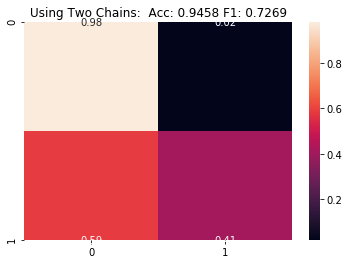

In [35]:
confusion_rnn(rnn_add, X_test, y_test_ohe, 'Two Chains')

## Visualize 

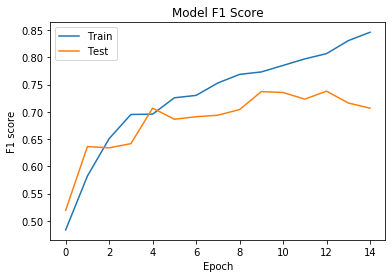

In [36]:
# Plot training & validation F1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

From the F1 score vs. epoch, we see that the F1 score continues to increase on the trainin data, but stops increasing by epoch 6 of test data. This means we have enough epochs as we are experiencing the beginning of overfitting. Overfitting occurrs when the training data improves but the test data actually begins to decrease. That does not really happen here, but if we had more training it might have happened.

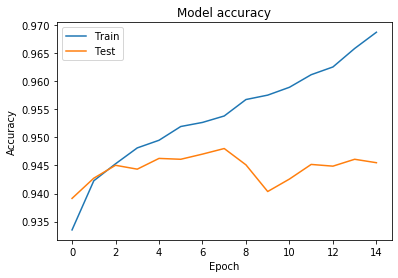

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The accuracy shows a similar pattern to the f1 score.

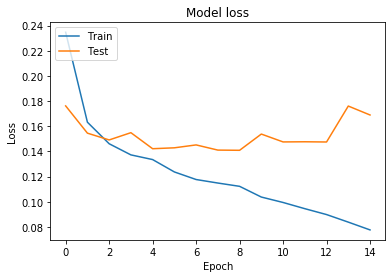

In [39]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Again, this shows a similar pattern. The loss continually decreases for the training data, but at around epoch 6, the test data stops improving.

## 2.3 Compare our best LSTM and best GRU ( 20 points)

In [43]:
def contingency_column_rnn(rnn, X_test, y_test):
    yhat_rnn = np.argmax(rnn.predict(X_test), axis = 1)
    y_rnn = np.argmax(y_test, axis = 1)
    
    print(yhat_rnn)
    print(y_rnn)
    return [yhat_rnn[i] == y_rnn[i] for i in range(len(yhat_rnn))]

## Our best model using lstm

In [22]:
rnn_lstm = Sequential()
rnn_lstm.add(embedding_layer)
rnn_lstm.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2,activation='relu',return_sequences=True))
rnn_lstm.add(GlobalMaxPool1D())
rnn_lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_lstm.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1])
print(rnn_lstm.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9015000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 32)           42624     
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
Total params: 9,057,690
Trainable params: 42,690
Non-trainable params: 9,015,000
_________________________________________________________________
None


In [61]:
lstm_history = rnn_lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=128)

Train on 26122 samples, validate on 6531 samples
Epoch 1/15
26122/26122 [==============================] - 62s 2ms/step - loss: 0.0589 - accuracy: 0.9789 - f1: 0.8930 - val_loss: 0.1632 - val_accuracy: 0.9443 - val_f1: 0.7261
Epoch 2/15
26122/26122 [==============================] - 51s 2ms/step - loss: 0.0557 - accuracy: 0.9809 - f1: 0.9005 - val_loss: 0.1673 - val_accuracy: 0.9448 - val_f1: 0.7097
Epoch 3/15
26122/26122 [==============================] - 45s 2ms/step - loss: 0.0505 - accuracy: 0.9824 - f1: 0.9131 - val_loss: 0.1720 - val_accuracy: 0.9449 - val_f1: 0.7090
Epoch 4/15
26122/26122 [==============================] - 44s 2ms/step - loss: 0.0450 - accuracy: 0.9838 - f1: 0.9186 - val_loss: 0.1823 - val_accuracy: 0.9445 - val_f1: 0.7172
Epoch 5/15
26122/26122 [==============================] - 45s 2ms/step - loss: 0.0434 - accuracy: 0.9849 - f1: 0.9268 - val_loss: 0.1811 - val_accuracy: 0.9440 - val_f1: 0.7305
Epoch 6/15
26122/26122 [==============================] - 45s 2ms/

In [62]:
classifier_lstm = contingency_column_rnn(rnn_lstm, X_test, y_test_ohe)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


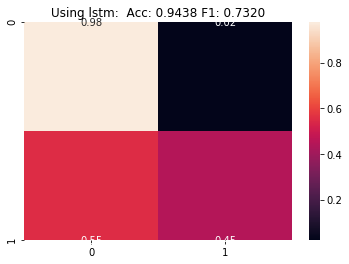

In [64]:
confusion_rnn(rnn_lstm, X_test, y_test_ohe, 'lstm')

## Our best model using gru

In [23]:
rnn_gru = Sequential()
rnn_gru.add(embedding_layer)
rnn_gru.add(GRU(64,dropout=0.2, recurrent_dropout=0.1,activation='relu',return_sequences=True))
rnn_gru.add(GlobalMaxPool1D())
rnn_gru.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_gru.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',f1])
print(rnn_gru.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9015000   
_________________________________________________________________
gru_9 (GRU)                  (None, 100, 64)           70080     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 130       
Total params: 9,085,210
Trainable params: 70,210
Non-trainable params: 9,015,000
_________________________________________________________________
None


In [66]:
gru_history = rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=128)

Train on 26122 samples, validate on 6531 samples
Epoch 1/15
26122/26122 [==============================] - 52s 2ms/step - loss: 0.2201 - accuracy: 0.9257 - f1: 0.5100 - val_loss: 0.1607 - val_accuracy: 0.9384 - val_f1: 0.5932
Epoch 2/15
26122/26122 [==============================] - 47s 2ms/step - loss: 0.1612 - accuracy: 0.9461 - f1: 0.6570 - val_loss: 0.1511 - val_accuracy: 0.9412 - val_f1: 0.6229
Epoch 3/15
26122/26122 [==============================] - 42s 2ms/step - loss: 0.1437 - accuracy: 0.9480 - f1: 0.6955 - val_loss: 0.1515 - val_accuracy: 0.9416 - val_f1: 0.6905
Epoch 4/15
26122/26122 [==============================] - 48s 2ms/step - loss: 0.1314 - accuracy: 0.9508 - f1: 0.7147 - val_loss: 0.1460 - val_accuracy: 0.9441 - val_f1: 0.6338
Epoch 5/15
26122/26122 [==============================] - 48s 2ms/step - loss: 0.1261 - accuracy: 0.9521 - f1: 0.7210 - val_loss: 0.1419 - val_accuracy: 0.9460 - val_f1: 0.6614
Epoch 6/15
26122/26122 [==============================] - 41s 2ms/

In [67]:
classifier_gru = contingency_column_rnn(rnn_gru, X_test, y_test_ohe)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


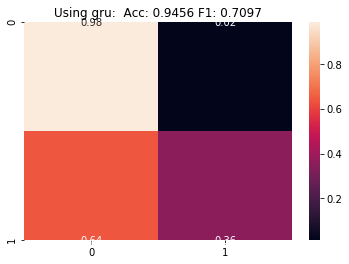

In [69]:
confusion_rnn(rnn_gru, X_test, y_test_ohe, 'gru')

## Mcnemara's Test

In statistics, McNemar's test is a statistical test used on paired nominal data. It is applied to 2 × 2 contingency tables with a dichotomous trait, with matched pairs of subjects, to determine whether the row and column marginal frequencies are equal (that is, whether there is "marginal homogeneity")

The test is applied to a 2 × 2 contingency table, which tabulates the outcomes of two tests on a sample of n subjects, as follows.

</h2><table class='table table-striped'> <thead> <tr> <th></th> <th>Test 2 positive</th> <th>Test 2 negative</th> <th>Rowtotal</th> </tr> </thead> <tbody> <tr> <th scope='row'>Test 1 positive</th> <td>a</td> <td>b</td> <td>a+b</td> </tr> <tr> <th scope='row'>Test 1 negative</th> <td>c</td> <td>d</td> <td>c+d</td> </tr> <tr> <th scope='row'>Column total</th> <td>a+c</td> <td>b+d</td> <td>n</td> </tr> </tbody> </table>

The null hypothesis of marginal homogeneity states that the two marginal probabilities for each outcome are the same, i.e. \begin{aligned}~p_{a}+p_{b}=p_{b} + p_{c}~and~p_{c} + p_{d}=p_{b} + p_{d}\end{aligned}

Thus the null and alternative hypotheses are[1]

\begin{aligned}H_{0}&:~p_{b}=p_{c}\\H_{1}&:~p_{b}\neq p_{c}\end{aligned}
Here $p_{a}$, etc., denote the theoretical probability of occurrences in cells with the corresponding label.

The McNemar test statistic is:
\begin{aligned}{\chi^2} = \frac{(b-c)^2}{b-c}\end{aligned}

Under the null hypothesis, with a sufficiently large number of discordants (cells b and c), $\chi^2$ has a chi-squared distribution with 1 degree of freedom. If the $\chi^2$ result is significant, this provides sufficient evidence to reject the null hypothesis, in favour of the alternative hypothesis that $p_{b} ≠ p_{c}$, which would mean that the marginal proportions are significantly different from each other.

## Reference 
“McNemar's Test.” Wikipedia, Wikimedia Foundation, 22 Nov. 2019, https://en.wikipedia.org/wiki/McNemar's_test.

In [70]:
def make_contingency_table(classifier_1, classifier_2):
    '''
    input: classifier 1 right or wrong, classifier 2 right or wrong
    '''
    table = [[0, 0],[0,0]]
    for i in range(len(classifier_1)):
        if classifier_1[i]:
            i_ans = 0
        else:
            i_ans = 1
        if classifier_2[i]:
            j_ans = 0
        else:
            j_ans = 1
        table[i_ans][j_ans] += 1
    return table

In [71]:
#!pip install statsmodels

In [72]:
# Code taken form https://machinelearningmastery.com/mcnemars-test-for-machine-learning/

# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[4, 2], [2,4]]
def print_mcnemar(table):         
    # calculate mcnemar test
    result = mcnemar(table, exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

print_mcnemar(table)

statistic=2.000, p-value=1.000
Same proportions of errors (fail to reject H0)


In [73]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[4, 2], [2,4]]

In [74]:
make_contingency_table(classifier_lstm,  classifier_gru)

[[6068, 96], [108, 259]]

From the contigency table, we can see that gru model got 108 prediction right that lstm model got wrong. Vice versa, lstm model got 96 prediction right that gru model got wrong.

In [75]:
print_mcnemar(make_contingency_table(classifier_lstm,classifier_gru))

statistic=96.000, p-value=0.441
Same proportions of errors (fail to reject H0)


Text(0.5, 1.0, 'Comparison of f1 Score for best lstm and best gru')

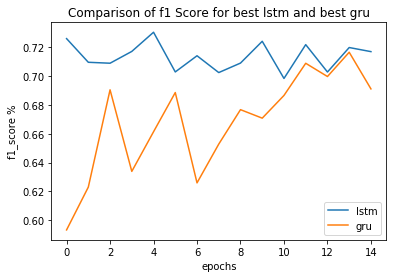

In [79]:
#Compare our best model 
plt.plot(lstm_history.history['val_f1'])
plt.plot(gru_history.history['val_f1'])
plt.legend(['lstm','gru'])
plt.ylabel('f1_score %')
plt.xlabel('epochs')
plt.title('Comparison of f1 Score for best lstm and best gru')

Based on the plots above, lstm model performs better on almost every epoch. We visualized the results of all the RNNs we trained in confusion matrix.